# Module 1: Binary Images

In this module, I'll explore segmenting binary images and using iterative modification

In [51]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from collections import deque 
import binary_segmentation as bseg

Binary images are images with only 0's and 1's as values rather than the usual values for colors. These images are the easiest to work with because of their simple respresentation. Unfortunately, capturing binary images is not so easy, especially as they require thresholding and controlled lighting environments.

Below is an example of a well lit [pineapple](https://images.unsplash.com/photo-1550258987-190a2d41a8ba?ixlib=rb-1.2.1&w=1000&q=80) (shoutout Pysch) that will show how thresholding may lead to noise or wanted holes.

(np.float64(-0.5), np.float64(999.5), np.float64(1499.5), np.float64(-0.5))

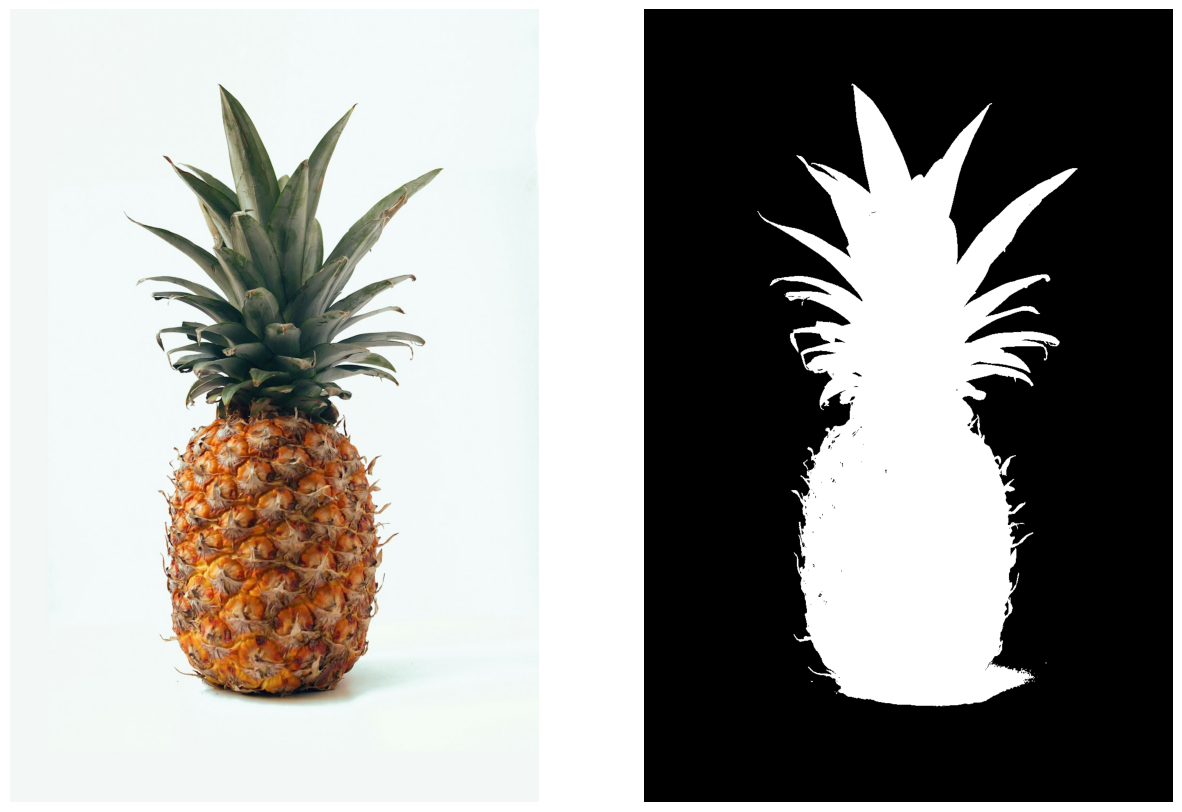

In [53]:
pineapple = cv2.cvtColor(cv2.imread(rf"Data/pineapple.png"), cv2.COLOR_BGR2RGB)
binary_pineapple = np.where(cv2.cvtColor(pineapple, cv2.COLOR_RGB2GRAY) > 230, 0, 1)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(pineapple)
ax[1].imshow(binary_pineapple, cmap='gray')

ax[0].axis('off')
ax[1].axis('off')

This next example of a [butterfly](https://www.pngrepo.com/png/256208/512/butterfly.png) is ideal as it has no noise, meaning it will be easily converted into a binary image!

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

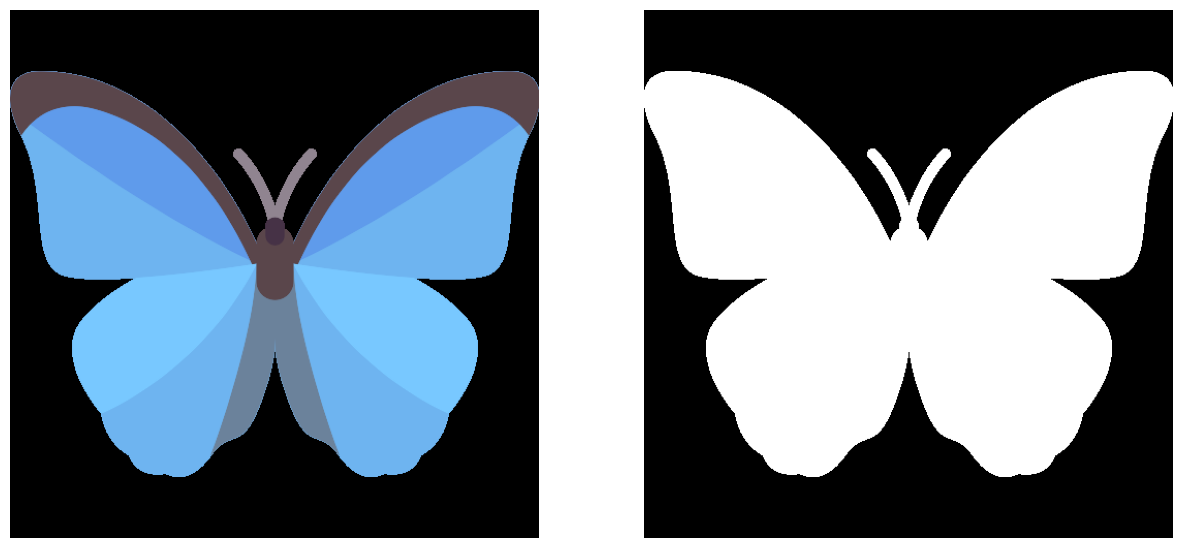

In [54]:
butterfly = cv2.cvtColor(cv2.imread(rf'Data/butterfly.png'), cv2.COLOR_BGR2RGB)
binary_butterfly = np.where(cv2.cvtColor(butterfly, cv2.COLOR_RGB2GRAY) > 0, 1, 0)

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(butterfly)
ax[1].imshow(binary_butterfly, cmap='gray')

ax[0].axis('off')
ax[1].axis('off')

### Segmenting Binary Images
In this part of the notebook, I'll go through 2 different methods for labeling connected components

The first method is using the **Region Growing Algorithm**, a method based mostly on DFS (from what I can tell). It's as follows:
1. Find unlabeled "seed" point with value = 1
    - if such a point does not exist, *end*
2. Assign label to seed
3. Assign sam label to all neighbors of seed w/ value = 1(DFS)
4. Repeat Step 3 until there are no more valid neighbors
5. Go to Step 1

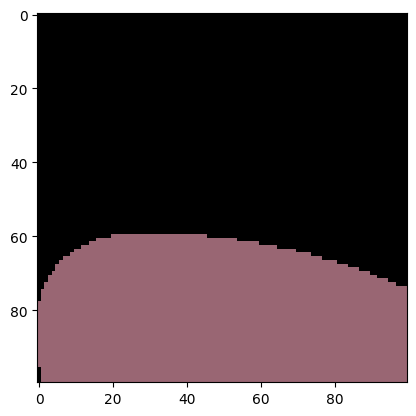

In [56]:
labels, labeled = bseg.region_growing_alg(binary_butterfly[:100, :100])
plt.imshow(bseg.color_segmentations(labels, labeled))

This case is almost too simple as there's only 1 object, however the algorithm will handle as many labels as necessary. The main complication actually arises in the size limitation. Even segmenting just the butterfly causes memory issues as the recursive stack gets too large (which is why the case above is only the top left of the wing)

Instead a BFS iterative approach will work better. Below is a modified version of the function above. As you can see, this time we can segment out the entire butterfly!

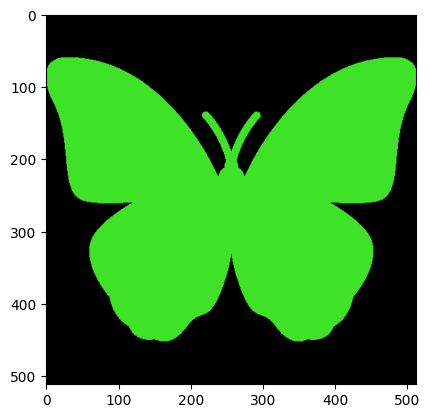

In [58]:
labels, labeled = bseg.region_grow_bfs(binary_butterfly)
plt.imshow(bseg.color_segmentations(labels, labeled))

In [59]:
from skimage import data
blobs = np.where(data.binary_blobs() == True, 1, 0)
blob_labels, blob_labeled = bseg.region_grow_bfs(blobs)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

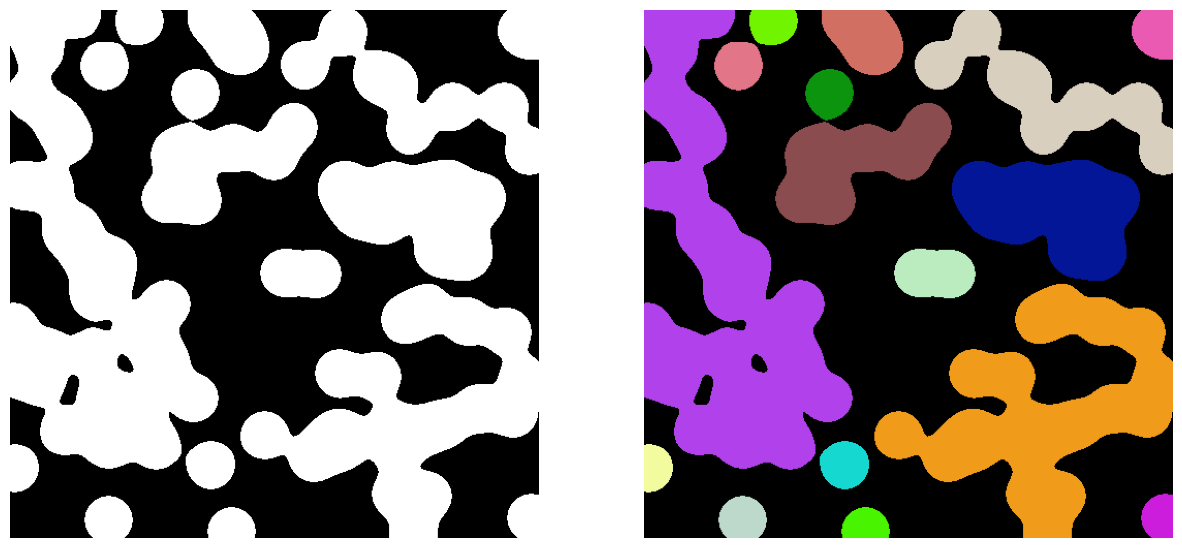

In [60]:
label_colors = {l:(255/len(blob_labels) *i + 20) for i, l in enumerate(list(blob_labels))}
blob_colored = blob_labeled.copy()
for l, v in label_colors.items():
    blob_colored[blob_colored == l] = v

fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(blobs, cmap='gray')
ax[1].imshow(bseg.color_segmentations(blob_labels, blob_labeled))

ax[0].axis('off')
ax[1].axis('off')

The examples above use 4-Connectedness to define neighbors. Unfortunately neither 4-C nor 8-C preserves Jordan's Curve Theorem for creating 2 connected regions when segmenting something with a closed curve. For example:

$\begin{bmatrix}0 &1 &0\\1 &0 &1\\0 &1 &0 \end{bmatrix}$ => $\begin{bmatrix}B1 &O1 &B1\\O2 &B2 &04\\B1 &O4 & B1 \end{bmatrix}$ => $\begin{bmatrix}B &O &B\\ O &B &O\\ B &O &B \end{bmatrix}$

4-C (middle) shows that each object is separate and there's a hole, namely B2, in the middle

8-C (right) shows that although all objects are connected, there's a hole in the middle again

-----

*Instead* we'll opt to use 6-C! It introduces asymmetry to look more like a hexagon. We can use a Sequential Labeling Algorithm with Raster Scanning to efficiently handle edge cases. In this case, we assume B, C, D are labeled and assign A to a label accordingly.

$\begin{bmatrix}D &B\\C &A \end{bmatrix}$

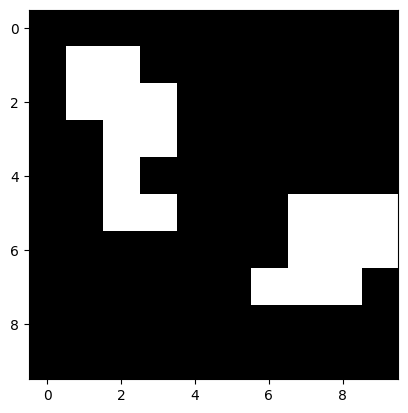

In [61]:
small_blob_1 = np.array([
    [0 , 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 1, 1, 1, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 1, 1, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 1, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 1, 1, 0, 0, 0, 1, 1, 1], 
    [0 , 0, 0, 0, 0, 0, 0, 1, 1, 1], 
    [0 , 0, 0, 0, 0, 0, 1, 1, 1, 0], 
    [0 , 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0 , 0, 0, 0, 0, 0, 0, 0, 0, 0]
])
plt.imshow(small_blob_1, cmap='gray')

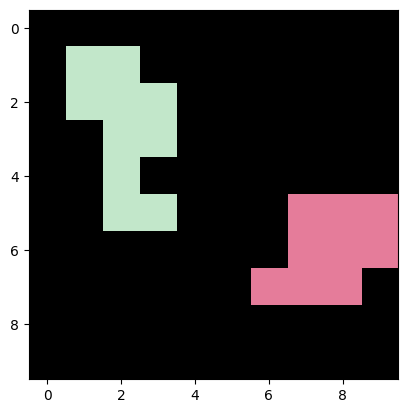

In [69]:
l, ld = bseg.seq_label_alg(small_blob_1)
plt.imshow(bseg.color_segmentations(l, ld))

In [67]:
blob_seq_labels, blob_seq_labeled = bseg.seq_label_alg(blobs)

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

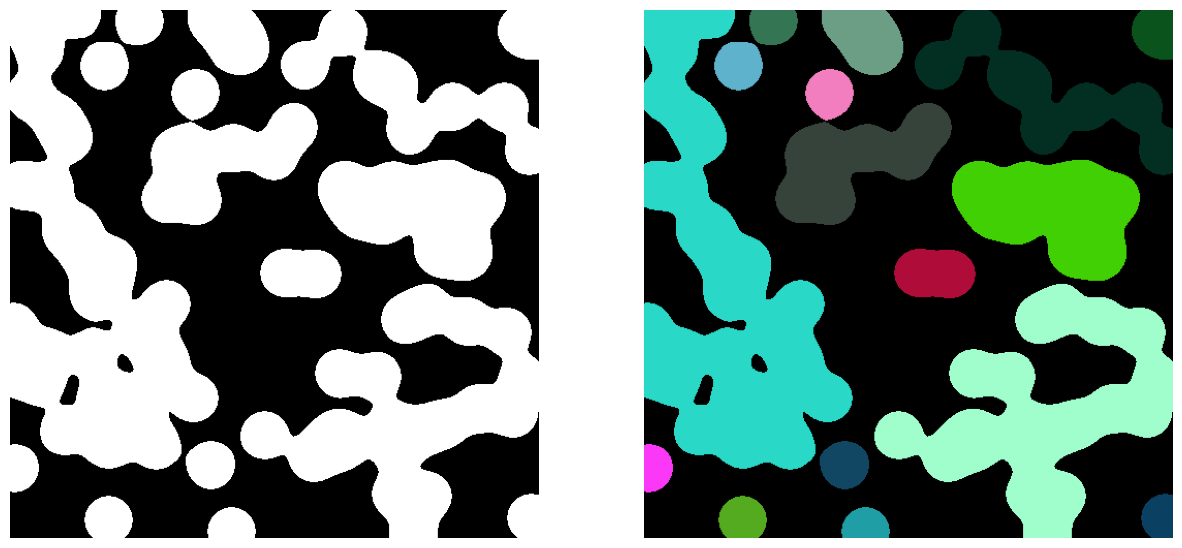

In [68]:
fig, ax = plt.subplots(1,2, figsize=(15,15))
ax[0].imshow(blobs, cmap='gray')
ax[1].imshow(bseg.color_segmentations(blob_seq_labels, blob_seq_labeled))

ax[0].axis('off')
ax[1].axis('off')

Iterative Modification is a way to extract information out of a binary image that doesn't introduce or remove new objects. For example, we could look to *thin* a binary image of a person to extract a rough skeleton of their position.

To maintain the same number of objects throughout the process, we need to define the Euler Number (E), yet another term named after Euler XD. Here, E = num of bodies - num of holes. We can also define the Euler Differential (E*) to be the change in E over two images such that $E^* = E_1 - E_0$. 

When swapping pixels from 0/1 or vice versa, we want to ensure that we DO NOT change E across images. In other words, $0 = E^*$ and $E_0 = E_1$. That means, out of the four neighborhood classes, we only care about $N_0$ over $N_1, N_{-1}, N_{-2}$ when looking at 6-C.